# Continuum effects

If dust is mixed with the gas, the photons emitted by the dust can be absorbed by the gas, thereby affecting its excitation conditions. This effect can easily be incorporated in `pythonradex`. Note that this effect cannot be treated with `RADEX`. Here we give some examples of calculations including a dust continuum.

## The total source function

For the following discussion, it is useful to consider how the radiation fields of the emission lines and dust continuum combine in terms of the source function. In general, the source function of an emission line is given by the Planck function evaluated at the excitation temperature $T_\mathrm{ex}$. On the other hand, the source function of the dust continuum is defined as the Planck function evaluated at the dust temperature in `pythonradex`. The total source function at a given frequency $\nu$ is the weighted average of the different components (line(s) plus dust continuum), where the weights are the optical depths:

$$S_\nu=\frac{\sum_i\tau_\nu^iS_\nu^i+\tau_dS_d}{\sum_i\tau_\nu^i+\tau_d}$$

The index $i$ runs over all emission lines and $S_d$ and $\tau_d$ are the source function and optical depth of the dust. In the following, we will consider the case without line overlap, so there is only a single emission line. Then the total source function is

$$S_\nu=\frac{S_\mathrm{line}\tau_{line}+S_d\tau_d}{\tau_\mathrm{line}+\tau_d}=\frac{B_\nu(T_\mathrm{ex})\tau_\mathrm{line}+B_\nu(T_d)\tau_d}{\tau_\mathrm{tot}}$$

where $\tau_\mathrm{tot}=\tau_\mathrm{line}+\tau_d$. Please note that $\tau_\mathrm{line}$ is a function of $\nu$, while $\tau_d$ may or may not vary with $\nu$. For a static slab, the total spectrum (line + dust) is then given by

$$F_\nu=S_\nu(1-e^{-\tau_\mathrm{tot}})$$

## Simple example with dust continuum

We consider the radiative transfer of CO 2-1 including a dust continuum field

In [1]:
from pythonradex import radiative_transfer,helpers
from scipy import constants
import matplotlib.pyplot as plt
import numpy as np

In [2]:
datafilepath = './co.dat' #file downloaded from EMAA or LAMDA database
geometry = 'static slab'
line_profile_type = 'Gaussian'
width_v = 2*constants.kilo #intrinsic line width of 2 km/s
source = radiative_transfer.Source(datafilepath=datafilepath,geometry=geometry,
                                 line_profile_type=line_profile_type,width_v=width_v)

In [3]:
#First, let's consider the case without dust:
N = 5e15/constants.centi**2
Tkin = 20
collider_densities = {'para-H2':1e2/constants.centi**3,'ortho-H2':1e2/constants.centi**3}
ext_background = 0
source.update_parameters(N=N,Tkin=Tkin,collider_densities=collider_densities,
                        ext_background=ext_background,T_dust=0,tau_dust=0)
source.solve_radiative_transfer()

Check the results, focussing on CO 2-1:

In [4]:
ref_line_index = 1 #CO 2-1
def print_results():
    print(f'Tex = {source.Tex[ref_line_index]:.3g}')
    print(f'tau_nu0 = {source.tau_nu0_individual_transitions[ref_line_index]:.4g}')

print_results()

Tex = 4.42
tau_nu0 = 1.016


We also calculate the spectrum (specific intensity):

In [5]:
v = np.linspace(-2.5*width_v,2.5*width_v,100)
#convert velocity to frequency by using the rest frequency:
nu = source.emitting_molecule.nu0[ref_line_index] * (1-v/constants.c)
specific_intensity_without_dust = source.spectrum(output_type="specific intensity",nu=nu)

Now do a calculation with dust, for comparison. Consider an optically thin dust field.

In [6]:
T_dust = 100
tau_dust = 0.05
source.update_parameters(T_dust=T_dust,tau_dust=tau_dust)
source.solve_radiative_transfer()
print_results()
specific_intensity_with_dust = source.spectrum(output_type="specific intensity",nu=nu)

Tex = 12
tau_nu0 = 0.5484


We see that the dust field is increasing the excitation temperature of the CO line, because the line can be excited by dust photons.
Now compare the spectra:

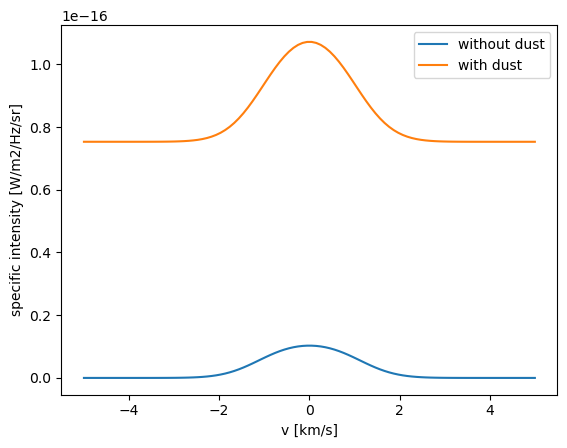

In [7]:
fig,ax = plt.subplots()
ax.plot(v/constants.kilo,specific_intensity_without_dust,label='without dust')
ax.plot(v/constants.kilo,specific_intensity_with_dust,label='with dust')
ax.set_xlabel('v [km/s]')
ax.set_ylabel('specific intensity [W/m2/Hz/sr]')
ax.legend(loc='best')

We clearly see the continuum component for the model with dust.

## Optically thick dust

If $\tau_d\gg\tau_\mathrm{line}$, the total source function approaches the source function of the dust. Let's demonstrate this by considering a dust field with high optical depth:

In [8]:
source.update_parameters(T_dust=100,tau_dust=50)
source.solve_radiative_transfer()
print_results()

Tex = 95.6
tau_nu0 = 0.02043


The excitation temperature of the CO line is now much higher than the kinetic temperature of the gas itself, thanks to the excitation from the strong dust continuum.

It is instructive to plot the spectrum in terms of brightness temperature:

(0.0, 109.99999999994112)

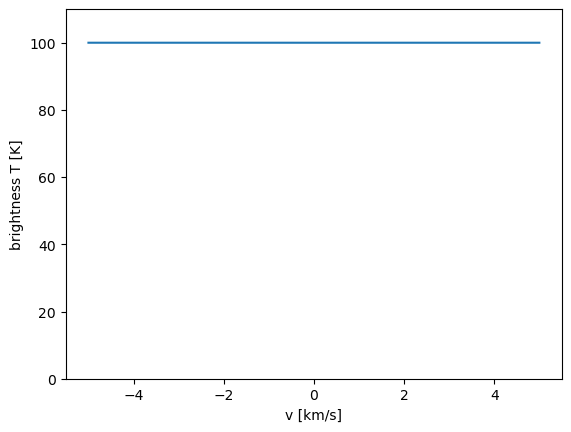

In [9]:
brightness_T_with_thick_dust = source.spectrum(output_type="Planck",nu=nu)
fig,ax = plt.subplots()
ax.plot(v/constants.kilo,brightness_T_with_thick_dust)
ax.set_xlabel('v [km/s]')
ax.set_ylabel('brightness T [K]')
ax.set_ylim(ymin=0,ymax=1.1*np.max(brightness_T_with_thick_dust))

As expected, the spectrum is flat because the source function is completely dominated by the dust. It is simply a black body with a temperature equal to the dust temperature.

On the other hand, what happens if $\tau_\mathrm{line}\gg\tau_d$? In that case, we expect that the source function at the line center equals $B_\nu(T_\mathrm{ex})$ (while outside of the line region, it should of course equal the source function of the dust). Let's check this:

In [10]:
#put high column density to make CO strongly optically thick
source.update_parameters(N=1e20/constants.centi**2)
source.solve_radiative_transfer()
print_results()

Tex = 69.3
tau_nu0 = 629.2


Now CO is much thicker than the dust (remember: we set the dust optical depth to 50)

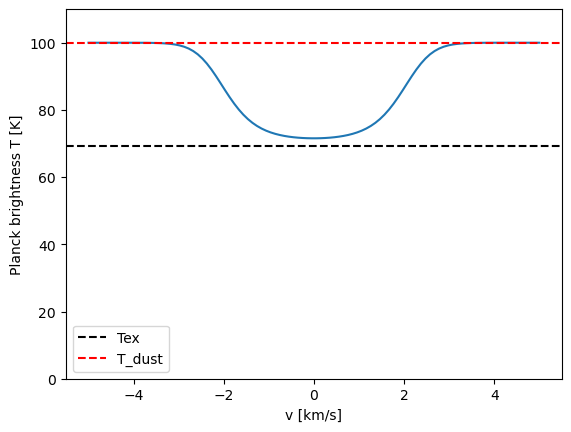

In [11]:
brightness_T_with_thick_dust_and_thick_gas = source.spectrum(output_type="Planck",nu=nu)
fig,ax = plt.subplots()
ax.plot(v/constants.kilo,brightness_T_with_thick_dust_and_thick_gas)
ax.axhline(source.Tex[ref_line_index],linestyle='dashed',label='Tex',color='black')
ax.axhline(T_dust,linestyle='dashed',label='T_dust',color='red')
ax.set_xlabel('v [km/s]')
ax.set_ylabel('Planck brightness T [K]')
ax.set_ylim(ymin=0,ymax=1.1*np.max(brightness_T_with_thick_dust_and_thick_gas))
ax.legend(loc='best')

Indeed, at the wavelengths of the CO line, we see the CO source function, i.e. black body radiation at the excitation temperature of CO (the spectrum equals the source function in the limit of infinite optical depth). Outside of the CO line, we see the source function of the dust, i.e. black body radiation at the dust temperature.

Finally, let's consider an example where the dust is thin and the CO is thick:

Tex = 19.7
tau_nu0 = 5.866


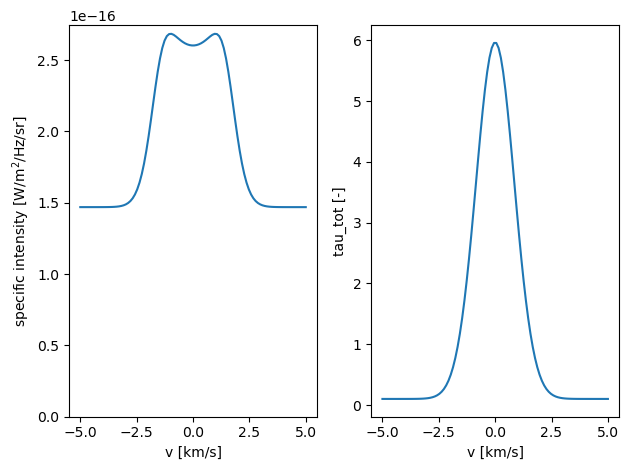

In [12]:
tau_dust = 0.1
source.update_parameters(tau_dust=tau_dust,N=1e17/constants.centi**2)
source.solve_radiative_transfer()
print_results()
specific_intensity = source.spectrum(output_type="specific intensity",nu=nu)
tau_tot = source.tau_nu(nu=nu)
fig,axes = plt.subplots(ncols=2)
axes[0].plot(v/constants.kilo,specific_intensity)
axes[0].set_ylabel(r'specific intensity [W/m$^2$/Hz/sr]')
axes[0].set_ylim(ymin=0)
axes[1].plot(v/constants.kilo,tau_tot)
axes[1].set_ylabel('tau_tot [-]')
for ax in axes:
    ax.set_xlabel('v [km/s]')
fig.tight_layout()

The spectrum has a depression at the line core. How can we understand this interesting shape? Let us consider the flux as a function of the line optical depth (the other parameters being fixed):

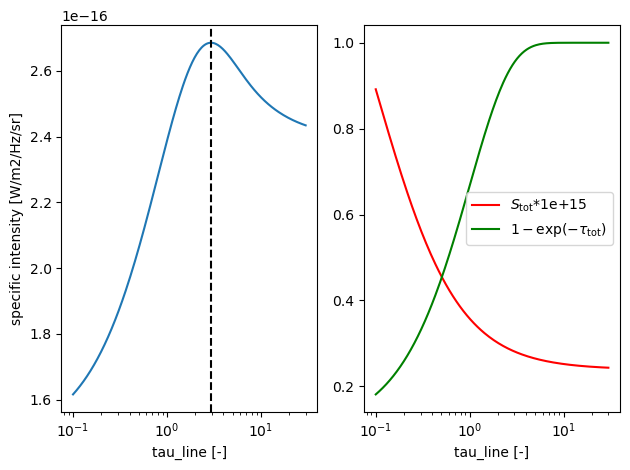

In [13]:
nu0 = source.emitting_molecule.nu0[ref_line_index]
Tex = source.Tex[ref_line_index]
#to a very good approximation, we can evaluate everything at nu0:
S_line = helpers.B_nu(nu=nu0,T=Tex)
S_dust = helpers.B_nu(nu=nu0,T=T_dust)
def calculate_specific_intensity(tau_line):
    tau_tot = tau_line+tau_dust
    S_tot = (tau_line*S_line+tau_dust*S_dust)/tau_tot
    exp_term = (1-np.exp(-tau_tot))
    #note that the following formula only applies to a
    #static slab geometry
    I = S_tot*exp_term
    return S_tot,exp_term,I

tau_line_values = np.logspace(-1,np.log10(30),200)
S_tot,exp_term,specific_intensity = calculate_specific_intensity(tau_line_values)
fig,axes = plt.subplots(ncols=2)
axes[0].plot(tau_line_values,specific_intensity)
axes[0].set_ylabel('specific intensity [W/m2/Hz/sr]')
#put a vertical line to mark the maximum:
axes[0].axvline(tau_line_values[np.argmax(specific_intensity)],
                linestyle='dashed',color='black')
Stot_scaling = 1e15
axes[1].plot(tau_line_values,S_tot*Stot_scaling,
             label=r'$S_\mathrm{tot}$'+f'*{Stot_scaling:.1g}',color='red')
axes[1].plot(tau_line_values,exp_term,label=r'$1-\exp(-\tau_\mathrm{tot})$',
            color='green')
#axes[1].set_yscale('log')
axes[1].legend(loc='best')
for ax in axes:
    ax.set_xlabel('tau_line [-]')
    ax.set_xscale('log')
fig.tight_layout()

The left panel shows that the maximum specific intensity is occuring when the CO line has an optical depth of ${\sim}3$. This is exactly what we see in the spectrum. The right panel shows why this occurs: as the CO optical depth increases, the term $1-\exp(-\tau_\mathrm{tot})$ increases, but the total source function $S_\mathrm{tot}$ decreases, meaning that the specific intensity $I=S_\mathrm{tot}(1-\exp(-\tau_\mathrm{tot}))$ has a maximum at $\tau_\mathrm{CO}\sim3$. In the line core, the CO optical depth is ${\sim}6$, so we essentially see a black body at the excitation temperature of CO 2-1, which provides a lower flux than the combination of line and continuum at $\tau_\mathrm{CO}\sim3$. Note that this is because $T_\mathrm{ex}\ll T_d$. Let's verify by increasing the excitation temperature of CO 2-1:

Tex = 200
tau_nu0 = 5.129


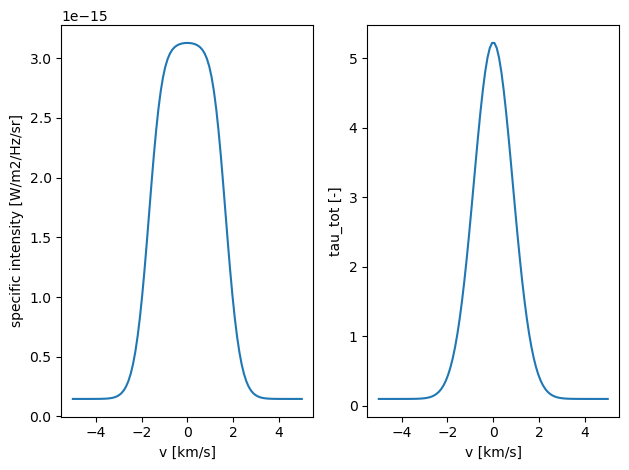

In [14]:
#increase kinetic temperature and force LTE;
#also increase N to have similar CO optical depth as before
source.update_parameters(
      Tkin=200,collider_densities={coll:1e6/constants.centi**3
                                   for coll in ('para-H2','ortho-H2')},
      N=5e18/constants.centi**2)
source.solve_radiative_transfer()
print_results()
specific_intensity = source.spectrum(output_type="specific intensity",nu=nu)
tau_tot = source.tau_nu(nu=nu)
fig,axes = plt.subplots(ncols=2)
axes[0].plot(v/constants.kilo,specific_intensity)
axes[0].set_ylabel('specific intensity [W/m2/Hz/sr]')
axes[1].plot(v/constants.kilo,tau_tot)
axes[1].set_ylabel('tau_tot [-]')
for ax in axes:
    ax.set_xlabel('v [km/s]')
fig.tight_layout()

Now the depression at the line core is not present anymore.